# SMCNOD - Member Probability

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat

## Data
with quality cuts

In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5

absdev_1700d_0,absdev_580v_0,alpha1,alpha16,alpha50,alpha84,alpha99,alpha_kurt,alpha_mean,alpha_skew,alpha_std,chisq_1700d_0,chisq_580v_0,chisq_cont_1700d_0,chisq_cont_580v_0,comment,dec,feh1,feh16,feh50,feh84,feh99,feh_kurt,feh_mean,feh_skew,feh_std,field,fig_name,fileinfo,logg1,logg16,logg50,logg84,logg99,logg_kurt,logg_mean,logg_skew,logg_std,name,nspec_1700d,nspec_580v,prior_type,proc_file_list,ra,redchisq_1700d_0,redchisq_580v_0,sn_1700d_0,sn_580v_0,teff1,teff16,teff50,teff84,teff99,teff_kurt,teff_mean,teff_skew,teff_std,utmjd,utmjd_mean,vel1,vel16,vel50,vel84,vel99,vel_blue1,vel_blue16,vel_blue50,vel_blue84,vel_blue99,vel_blue_kurt,vel_blue_mean,vel_blue_skew,vel_blue_std,vel_kurt,vel_mean,vel_skew,vel_std,fname,absdev_580v_1,chisq_580v_1,chisq_cont_580v_1,redchisq_580v_1,sn_580v_1,absdev_1700d_1,chisq_1700d_1,chisq_cont_1700d_1,redchisq_1700d_1,sn_1700d_1,absdev_1700d_2,chisq_1700d_2,chisq_cont_1700d_2,redchisq_1700d_2,sn_1700d_2,absdev_580v_2,chisq_580v_2,chisq_cont_580v_2,redchisq_580v_2,sn_580v_2,absdev_1700d_3,absdev_1700d_4,absdev_1700d_5,absdev_580v_3,absdev_580v_4,absdev_580v_5,chisq_1700d_3,chisq_1700d_4,chisq_1700d_5,chisq_580v_3,chisq_580v_4,chisq_580v_5,chisq_cont_1700d_3,chisq_cont_1700d_4,chisq_cont_1700d_5,chisq_cont_580v_3,chisq_cont_580v_4,chisq_cont_580v_5,redchisq_1700d_3,redchisq_1700d_4,redchisq_1700d_5,redchisq_580v_3,redchisq_580v_4,redchisq_580v_5,sn_1700d_3,sn_1700d_4,sn_1700d_5,sn_580v_3,sn_580v_4,sn_580v_5,ebv,gaia_source_id,dr2_source_id,phot_bp_rp_excess_factor,parallax,parallax_error,phot_g_mean_mag,source_id,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_bp_mean_mag,phot_rp_mean_mag,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bjdist_flag,w1mpro,w2mpro,w1sigmpro,w2sigmpro,j_2mass,h_2mass,k_2mass,u_skm,e_u_skm,v_skm,e_v_skm,g_skm,e_g_skm,r_skm,e_r_skm,i_skm,e_i_skm,z_skm,e_z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,qso_flag_wise,priority,object_name,sesar_s3ab,sesar_s3c,gaia_rr,p_bhb_decals,best_chisq_580v,best_absdev_580v,best_sn_580v,best_chisq_1700d,best_absdev_1700d,best_sn_1700d,good_star_pb,good_star,vel_calib,vel_calib_std,feh_calib_std,mass1,mass16,mass50,mass84,mass99,mass_mean,mass_std,mass_kurt,mass_skew,logage1,logage16,logage50,logage84,logage99,logage_mean,logage_std,logage_kurt,logage_skew,sp_feh1,sp_feh16,sp_feh50,sp_feh84,sp_feh99,sp_feh_mean,sp_feh_std,sp_feh_kurt,sp_feh_skew,sp_alpha1,sp_alpha16,sp_alpha50,sp_alpha84,sp_alpha99,sp_alpha_mean,sp_alpha_std,sp_alpha_kurt,sp_alpha_skew,logdist1,logdist16,logdist50,logdist84,logdist99,logdist_mean,logdist_std,logdist_kurt,logdist_skew,lmag_sys1,lmag_sys16,lmag_sys50,lmag_sys84,lmag_sys99,lmag_sys_mean,lmag_sys_std,lmag_sys_kurt,lmag_sys_skew,npost,sp_feh_calib_std,GDR3_solution_id,GDR3_source_id,GDR3_classprob_dsc_combmod_quasar,GDR3_classprob_dsc_combmod_galaxy,GDR3_classprob_dsc_combmod_star,GDR3_classprob_dsc_combmod_whitedwarf,GDR3_classprob_dsc_combmod_binarystar,GDR3_classprob_dsc_specmod_quasar,GDR3_classprob_dsc_specmod_galaxy,GDR3_classprob_dsc_specmod_star,GDR3_classprob_dsc_specmod_whitedwarf,GDR3_classprob_dsc_specmod_binarystar,GDR3_classprob_dsc_allosmod_quasar,GDR3_classprob_dsc_allosmod_galaxy,GDR3_classprob_dsc_allosmod_star,GDR3_teff_gspphot,GDR3_teff_gspphot_lower,GDR3_teff_gspphot_upper,GDR3_logg_gspphot,GDR3_logg_gspphot_lower,GDR3_logg_gspphot_upper,GDR3_mh_gspphot,GDR3_mh_gspphot_lower,GDR3_mh_gspphot_upper,GDR3_distance_gspphot,GDR3_distance_gspphot_lower,GDR3_distance_gspphot_upper,GDR3_azero_gspphot,GDR3_azero_gspphot_lower,GDR3_azero_gspphot_upper,GDR3_ag_gspphot,GDR3_ag_gspphot_lower,GDR3_ag_gspphot_upper,GDR3_abp_gspphot,GDR3_abp_gspphot_lower,GDR3_abp_gspphot_upper,GDR3_arp_gspphot,GDR3_arp_gspphot_lower,GDR3_arp_gspphot_upper,GDR3_ebpminrp_gspphot,GDR3_ebpminrp_gspphot_lower,GDR3_ebpminrp_gspphot_upper,GDR3_mg_gspphot,GDR3_mg_gspphot_lower,GDR3_mg_gspphot_upper,GDR3

In [28]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [29]:
tab = table_cut
tab_1 = smcnod

In [30]:
len(tab)

291

In [31]:
len(tab_1)

150

## Posterior Parameters
mcmc result from full model

In [32]:
pgal =  0.589
pbg1 =  0.250
vhel =  101.761
lsigv =  1.322
feh =  -1.874
lsigfeh =  -0.517
vbg1 =  208.227
lsigvbg1 =  1.928
fehbg1 =  -1.571
lsigfeh1 =  -0.260
vbg2 =  43.040
lsigvbg2 =  1.776
fehbg2 =  -0.875
lsigfeh2 =  -0.385
pmra =  0.705
pmdec =  -1.129
theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2, pmra, pmdec

## Define Variables
The code define variables that are necessary for the next steps of the analysis, such as **radial velocity, metallicity, and proper motions**, and the respective errors, as well as creating arrays to store the proper motion data, and the covariance matrix. 

The code also assumes a uniform background and creates a dictionary containing some of these variables.

In [33]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [34]:
def memprob(theta):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in fe
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Compute log likelihood in pm
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh + lgal_pm
    ## exp of log
    gal = np.exp(lgal)
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg1_pm = np.log(data["pmnorm"])
    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh + lbg1_pm
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    lbg2_pm = np.log(data["pmnorm"])
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh + lbg2_pm
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = np.exp(lbgtot)
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

Now, check how many members we have are of "high" memberhsip probability.

To think about: what should the threshold for high memprob be set to?

In [35]:
sum(memprob(theta_opt) > 0.999)

147

In [36]:
sum(memprob(theta_opt) > 0.5)

173

In [37]:
# set the threshold to 0.5
tab['memberprob'] = memprob(theta_opt)
tab['membership'] = memprob(theta_opt) > 0.5
tab_good = tab[tab['memberprob'] > 0.5]

## Visualizations

/var/folders/9w/8jsv_f1j1t357nbjlwl197kr0000gn/T/ipykernel_8359/3856569363.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


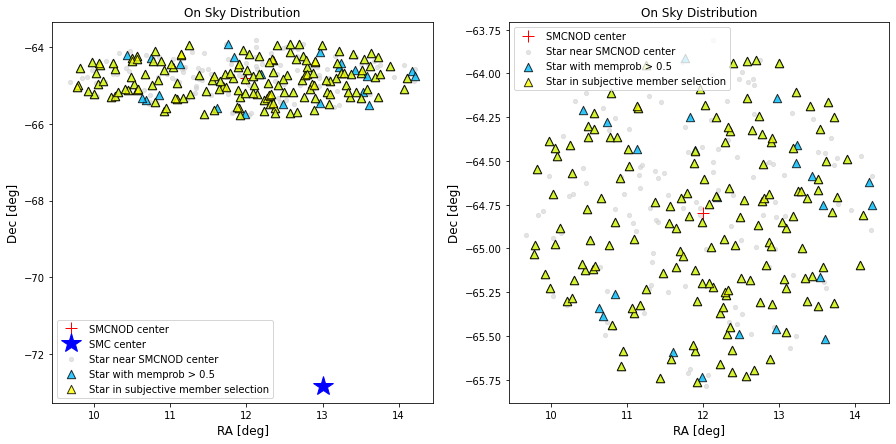

In [40]:
fig, ax = plt.subplots(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.plot(RA_smc, DEC_smc,'*b',ms=20,label="SMC center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='Star with memprob > 0.5')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, c='yellow', ec='k', zorder=3, alpha=0.8,
        label='Star in subjective member selection')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()
plt.subplot(1,2,2)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='Star with memprob > 0.5')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, c='yellow', ec='k', zorder=3, alpha=0.8,
        label='Star in subjective member selection')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

In [41]:
# cut
g_band = tab['decam_g'] - 3.185 * tab['ebv']
r_band = tab['decam_r'] - 2.140 * tab['ebv']
i_band = tab['decam_i'] - 1.569 * tab['ebv']
g_cut = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_cut = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_cut = tab_good['decam_i'] - 1.569 * tab_good['ebv']
table_iso = ascii.read('iso_a06.0_z0.00108.dat', header_start = 8)
g_iso = table_iso['DECam_g']
r_iso = table_iso['DECam_r']
# 18.96 ± 0.02 distance modulus in kpc
u_dm = 18.96

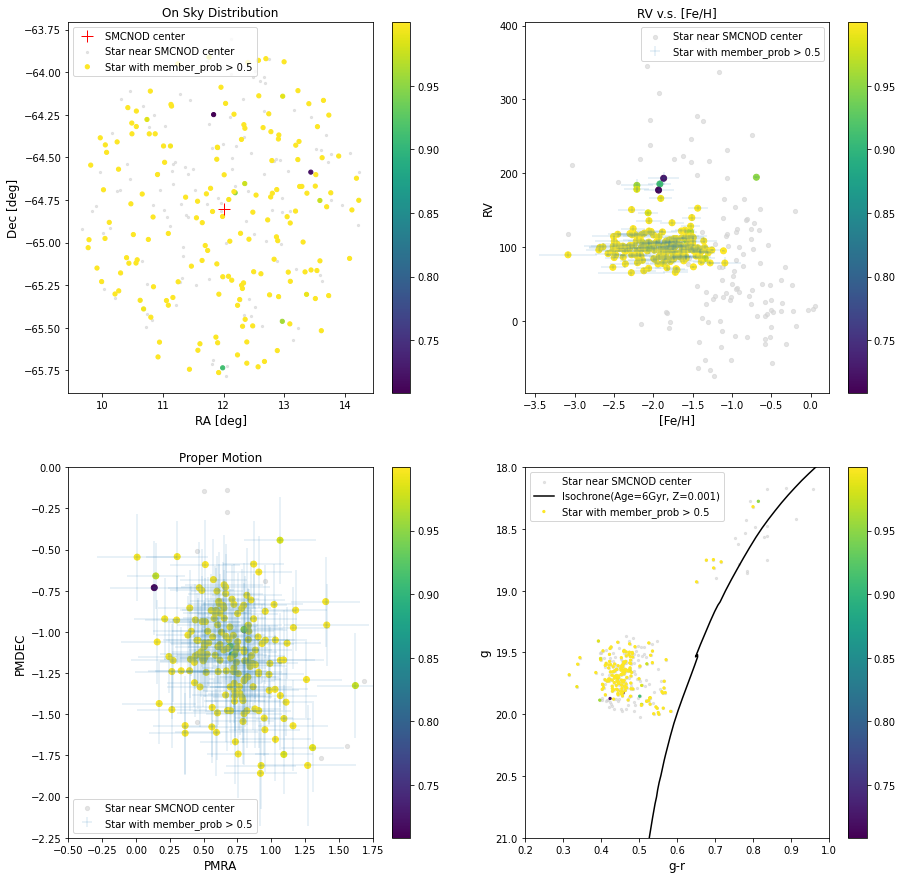

In [42]:
plt.figure(figsize=(15,15))
#plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(2,2,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()
plt.colorbar()
plt.subplot(2,2,2)
plt.scatter(tab['feh50'],tab['vel_calib'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], fmt='None', marker='None',lw=0.2,label='Star with member_prob > 0.5')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
plt.title('RV v.s. [Fe/H]')
plt.legend()
plt.colorbar()

plt.subplot(2,2,3)
plt.scatter(tab['pmra'],tab['pmdec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], c=tab_good['memberprob'],cmap='viridis')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], fmt='None', marker='None',lw=0.2,label='Star with member_prob > 0.5')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,1.75)
plt.ylim(-2.25,0)
plt.legend()
plt.colorbar()

plt.legend()
plt.subplot(2,2,4)
plt.scatter(g_band - r_band, g_band,marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center')
plt.plot(g_iso - r_iso, g_iso + u_dm, '-k', label = 'Isochrone(Age=6Gyr, Z=0.001)')
plt.scatter(g_cut - r_cut, g_cut, marker='.', s=20, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5')
plt.xlim(0.2,1.0)
plt.ylim(18,21)
plt.xlabel('g-r', size = 12)
plt.ylabel('g', size = 12)
plt.gca().invert_yaxis()
plt.legend()
plt.colorbar()
plt.savefig('memberselect.png')
plt.show()